In [ ]:
!pip install opendatasets --quiet

In [ ]:
# по API подключаемся к kaggle и скачиваем нужный датасет
# для этого в colab надо подгрузить файл kaggle.json, который содержит токен и пароль
# после этого в проводнике colab появится папка с данными
import opendatasets as od
import pandas as pd

# {"username":"biwanun1690","key":"2d817845937a4e0f6a59358471001da7"}
od.download( "https://www.kaggle.com/competitions/automated-video-captioning")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: biwanun1690
Your Kaggle Key: ··········


100%|██████████| 1.08G/1.08G [00:05<00:00, 219MB/s]



Extracting archive ./automated-video-captioning/automated-video-captioning.zip to ./automated-video-captioning


In [ ]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
train_csv_path = "/content/automated-video-captioning/train.csv"
test_csv_path = "/content/automated-video-captioning/test.csv"
train_dir = "/content/automated-video-captioning/train_videos"
test_dir = '/content/automated-video-captioning/test_videos'

In [ ]:
train_csv = pd.read_csv(train_csv_path)
test_csv = pd.read_csv(test_csv_path)
print(train_csv.shape[0], test_csv.shape[0])
train_csv

603 521


,index,file_name,caption
0,0,0.mp4,A man is working out on a seated chest press m...
1,1,1.mp4,Preparing a bowl with yogurt and assorted fres...
2,2,2.mp4,A man with a muscular build is seen from behin...
3,3,3.mp4,Man exercising by jogging on a pedestrian brid...
4,4,4.mp4,Wristwatch hands moving forward close-up views.
...,...,...,...
598,598,598.mp4,Terrifying Halloween pumpkin with a carved evi...
599,599,599.mp4,Cheerful girl sending messages on cell phone w...
600,600,600.mp4,A person in a light blue shirt is using a lapt...
601,601,601.mp4,"A top-down view of an aesthetic desk setup, wi..."


In [ ]:
train_csv['caption'] = train_csv['caption'].str.lower()

train_csv['caption'] = train_csv['caption'].str.replace("\r", "")
train_csv['caption'] = train_csv['caption'].str.replace("\n", "")
train_csv['caption'] = train_csv['caption'].str.replace("    ", " ")

import string
string.punctuation
punct = list(string.punctuation)
for sign in punct:
    train_csv['caption'] = train_csv['caption'].str.replace(sign, "")

import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
eng_stopwords = stopwords.words("english")

train_csv['caption'] = train_csv['caption'].str.split()
train_csv['caption'] = train_csv['caption'].apply(lambda words: [w for w in words if w not in eng_stopwords])
train_csv['caption'] = train_csv['caption'].apply(lambda words: " ".join(words))

train_csv

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,index,file_name,caption
0,0,0.mp4,man working seated chest press machine modern ...
1,1,1.mp4,preparing bowl yogurt assorted freshly chopped...
2,2,2.mp4,man muscular build seen behind intensely worki...
3,3,3.mp4,man exercising jogging pedestrian bridge city ...
4,4,4.mp4,wristwatch hands moving forward closeup views
...,...,...,...
598,598,598.mp4,terrifying halloween pumpkin carved evil face ...
599,599,599.mp4,cheerful girl sending messages cell phone taki...
600,600,600.mp4,person light blue shirt using laptop green scr...
601,601,601.mp4,topdown view aesthetic desk setup smooth leftt...


In [ ]:
from tokenizers import Tokenizer, models, trainers, pre_tokenizers, processors
from transformers import PreTrainedTokenizerFast

# 1. Создаем базовый токенизатор
tokenizer = Tokenizer(models.BPE())

# 2. Настраиваем пре-токенизатор (разбиение на слова)
tokenizer.pre_tokenizer = pre_tokenizers.Whitespace()

# 3. Создаем тренера
trainer = trainers.BpeTrainer(
    special_tokens=["[UNK]", "[PAD]", "[BOS]", "[EOS]"],
    #vocab_size=2000  # Желаемый размер словаря
)

# 4. Тренируем на ваших данных (пример)
corpus = list(train_csv['caption'].values)
tokenizer.train_from_iterator(corpus, trainer=trainer)

# 5. Добавляем пост-обработку (специальные токены)
tokenizer.post_processor = processors.TemplateProcessing(
    single="[BOS] $A [EOS]",
    pair="[BOS] $A [EOS] $B:1 [EOS]:1",
    special_tokens=[
        ("[BOS]", tokenizer.token_to_id("[BOS]")),
        ("[EOS]", tokenizer.token_to_id("[EOS]")),
    ],
)

# 6. Конвертируем в формат HuggingFace
fast_tokenizer = PreTrainedTokenizerFast(
    tokenizer_object=tokenizer,
    unk_token="[UNK]",
    pad_token="[PAD]",
    bos_token="[BOS]",
    eos_token="[EOS]",
)

# Сохраняем для будущего использования
fast_tokenizer.save_pretrained("tokenizer_video_to_text")

# Загрузка
# fast_tokenizer = PreTrainedTokenizerFast.from_pretrained("my_custom_tokenizer")

('tokenizer_video_to_text/tokenizer_config.json',
 'tokenizer_video_to_text/special_tokens_map.json',
 'tokenizer_video_to_text/tokenizer.json')

In [ ]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

nltk.download('punkt_tab')
nltk.download('punkt')
nltk.download('wordnet')

wordnet_lem = WordNetLemmatizer()

def lemmatize_text(text):
    tokenization = nltk.word_tokenize(text)
    lemmatized_words = [wordnet_lem.lemmatize(word) for word in tokenization]
    return " ".join(lemmatized_words)

train_csv['caption'] = train_csv['caption'].apply(lemmatize_text)

train_csv

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,index,file_name,caption
0,0,0.mp4,man working seated chest press machine modern ...
1,1,1.mp4,preparing bowl yogurt assorted freshly chopped...
2,2,2.mp4,man muscular build seen behind intensely worki...
3,3,3.mp4,man exercising jogging pedestrian bridge city ...
4,4,4.mp4,wristwatch hand moving forward closeup view
...,...,...,...
598,598,598.mp4,terrifying halloween pumpkin carved evil face ...
599,599,599.mp4,cheerful girl sending message cell phone takin...
600,600,600.mp4,person light blue shirt using laptop green scr...
601,601,601.mp4,topdown view aesthetic desk setup smooth leftt...


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(encoding = 'utf8', lowercase = False, sublinear_tf = True) #max_features= 50
features_train = tfidf.fit_transform(train_csv['caption']).toarray()
print(features_train.shape)
feature_names = tfidf.get_feature_names_out()
features_train_df = pd.DataFrame(features_train, columns=feature_names)

features_train_df

(603, 1893)


,3d,90degree,absolute,abstract,accentuates,accompanied,achieving,across,active,activewear,...,yellow,yellowed,yellowhued,yet,yoga,yogurt,yougurt,young,youth,zoom
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.281729,0.0,0.000000,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
598,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
599,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
600,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
601,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0


In [ ]:
train_сsv = pd.concat([train_csv, features_train_df], axis=1)
train_сsv.shape

(603, 1896)

In [ ]:
import torch
import cv2
import numpy as np
from PIL import Image

from torch.utils.data import DataLoader
import torchvision.transforms as transforms

def load_video_frames(video_path, max_frames=30, resize=(256, 256), transform=None):
    cap = cv2.VideoCapture(video_path)
    frames = []
    #n = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))//max_frames
    for i in range(max_frames):
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = Image.fromarray(frame)
        if transform:
            frame = transform(frame)
        frames.append(frame)
        cap.set(cv2.CAP_PROP_POS_FRAMES, int(cap.get(cv2.CAP_PROP_FRAME_COUNT))/(max_frames - i))
    cap.release()
    return torch.tensor(np.array(frames) / 255.0, dtype=torch.float32)  # [T, H, W, C]
    #video_tensor = torch.stack(frames)
    #return video_tensor

video_tensor = load_video_frames("/content/automated-video-captioning/train_videos/101.mp4").permute(0, 3, 1, 2)  # [T, C, H, W]

In [ ]:
video_tensor

tensor([[[[0.0784, 0.0784, 0.0784,  ..., 0.0549, 0.0549, 0.0549],
          [0.0784, 0.0784, 0.0784,  ..., 0.0627, 0.0627, 0.0627],
          [0.0824, 0.0824, 0.0824,  ..., 0.0784, 0.0784, 0.0745],
          ...,
          [0.0588, 0.0510, 0.0392,  ..., 0.0510, 0.0431, 0.0353],
          [0.0902, 0.0824, 0.0667,  ..., 0.0392, 0.0314, 0.0235],
          [0.1255, 0.1098, 0.0941,  ..., 0.0314, 0.0196, 0.0196]],

         [[0.0941, 0.0941, 0.0941,  ..., 0.0706, 0.0706, 0.0706],
          [0.0941, 0.0941, 0.0941,  ..., 0.0784, 0.0784, 0.0784],
          [0.0980, 0.0980, 0.0980,  ..., 0.0941, 0.0941, 0.0902],
          ...,
          [0.0667, 0.0588, 0.0471,  ..., 0.0510, 0.0431, 0.0353],
          [0.0980, 0.0902, 0.0745,  ..., 0.0392, 0.0314, 0.0235],
          [0.1333, 0.1176, 0.1020,  ..., 0.0314, 0.0196, 0.0196]],

         [[0.1020, 0.1020, 0.1020,  ..., 0.0784, 0.0784, 0.0784],
          [0.1020, 0.1020, 0.1020,  ..., 0.0863, 0.0863, 0.0863],
          [0.1059, 0.1059, 0.1059,  ..., 0

In [ ]:
import torch
from torch.utils.data import Dataset
from PIL import Image
import os
import numpy as np


class VideoDataset(Dataset):
    def __init__(self, dataframe, video_dir, transform=None, mode='train', num_frames=16):

        self.dataframe = dataframe.reset_index(drop=True)
        self.video_dir = video_dir
        self.transform = transform
        self.mode = mode
        self.num_frames = num_frames

        #if self.mode == 'train' or self.mode == 'val':
            #if 'labels' not in self.dataframe.columns:
                #raise ValueError("Dataframe must contain 'labels' column in train/val mode.")

    def __len__(self):
        return len(self.dataframe)

    def extract_frames(self, cap):
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        frame_indices = np.linspace(0, total_frames - 1, self.num_frames, dtype=int)

        frames = []
        for idx in frame_indices:
            cap.set(cv2.CAP_PROP_POS_FRAMES, idx)  # Переходим к нужному кадру
            ret, frame = cap.read()
            if not ret:
                frame = np.zeros((224, 224, 3), dtype=np.uint8)  # Запасной вариант
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = Image.fromarray(frame)
            if self.transform:
                frame = self.transform(frame)
            frames.append(frame)
        return frames

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        vid_path = os.path.join(self.video_dir, row['file_name'])
        cap = cv2.VideoCapture(vid_path)


        frames = self.extract_frames(cap)
        cap.release()
        #if not ret:
            #raise RuntimeError(f"Не удалось прочитать кадр из видео {vid_path}")
        video_tensor = torch.stack(frames)


        if self.mode in ['train', 'val']:
            caption = row.iloc[3:].astype(np.float32).values  # или .astype(int)
            return video_tensor, torch.tensor(caption)
        else:
            return video_tensor

In [ ]:
from sklearn.model_selection import train_test_split
train_encoded_csv, val_encoded_csv = train_test_split(train_csv, test_size=0.15, random_state=42)
print(train_encoded_csv.shape,  val_encoded_csv.shape)

(512, 3) (91, 3)


In [ ]:
def collate_fn(batch):
    videos, captions = zip(*batch)
    videos = torch.stack(videos)  # (B, T, C, H, W)
    #videos = videos.permute(0, 2, 1, 3, 4)  # -> (B, C, T, H, W)
    print("Batch shape:", videos.shape)
    return videos, torch.stack(captions)

torch.Size([8, 16, 3, 224, 224])


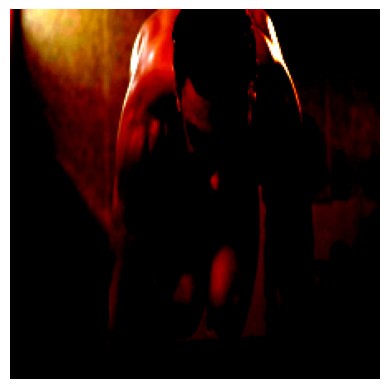

torch.Size([8, 0])
tensor([], size=(8, 0))
torch.Size([8, 16, 3, 224, 224])


In [ ]:
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import cv2

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = VideoDataset(train_encoded_csv,  video_dir=train_dir, transform=transform, mode='train')
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dataset = VideoDataset(val_encoded_csv,  video_dir=train_dir, transform=transform, mode='val')
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True)

for video, caption in val_loader:
    print(video.shape)
    img = video[0][0].permute(1, 2, 0)
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    print(caption.shape)
    print(caption)
    print(video.shape)
    break

In [ ]:
max_length_caption = train_csv['caption'].str.count(' ').max() + 1

In [ ]:
import torch.nn as nn
from torchvision.models import resnet50

In [ ]:
class VideoCaptioner(nn.Module):
    def __init__(self, vocab_size, device, hidden_size=256):
        super().__init__()
        # Энкодер (извлекает признаки из кадров)
        self.cnn = resnet50(pretrained=True)
        self.cnn.fc = nn.Identity()  # Удаляем последний слой
        self.device = device

        # Декодер (генерирует текст)
        self.rnn = nn.LSTM(input_size=2048, hidden_size=hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, video_frames, captions=None):
        # video_frames: [Batch, T, C, H, W]
        batch_size, T = video_frames.shape[0], video_frames.shape[1]
        frames_flat = video_frames.view(-1, *video_frames.shape[2:])  # [Batch*T, C, H, W]
        features = self.cnn(frames_flat)  # [Batch*T, 2048]
        features = features.view(batch_size, T, -1)  # [Batch, T, 2048]

        # Усреднение по времени
        video_features = features.mean(dim=1)  # [Batch, 2048]

        # Генерация текста (teacher forcing при обучении)
        if captions is not None:
            outputs, _ = self.rnn(video_features.unsqueeze(1).expand(-1, captions.size(1), -1))
            return self.fc(outputs)
        else:
            # Режим предсказания (пошаговая генерация)
            generated_words = []
            hiddens = None
            input_word = torch.tensor([0])  # Начальный токен <SOS>
            for _ in range(max_length_caption):
                output, hiddens = self.rnn(input_word.unsqueeze(0), hiddens)
                predicted_word = self.fc(output.squeeze(0))
                generated_words.append(predicted_word.argmax().item())
                input_word = predicted_word.argmax()
            return generated_words

In [ ]:
from transformers import VivitModel, GPT2LMHeadModel

class TransformerVideoCaptioner(nn.Module):
    def __init__(self, device=None):
        super().__init__()
        self.visual_encoder = VivitModel.from_pretrained("google/vivit-b-16x2-kinetics400")
        self.text_decoder = GPT2LMHeadModel.from_pretrained("gpt2")
        self.device = device

    def forward(self, video_frames, captions=None):
        print("Input shape:", video_frames.shape)
        outputs = self.visual_encoder(video_frames)
        print(outputs.shape)
        video_embeddings = outputs.last_hidden_state
        print(video_embeddings.shape)

        if captions is not None:
            return self.text_decoder(inputs_embeds=video_embeddings, labels=captions)
        else:
            return self.text_decoder.generate(inputs_embeds=video_embeddings)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [ ]:
#model = VideoCaptioner(vocab_size=1893, device=device)
#model = TransformerVideoCaptioner(device=device)

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup
from tqdm import tqdm
import numpy as np
import json

In [ ]:
def train_epoch(model, optimizer, criterion, scheduler, device, history):
    model.train()
    total_loss = 0

    for batch in tqdm(train_loader, desc="Training"):
        video_frames = batch[0].to(device)
        captions = batch[1].to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = model(video_frames, captions)
        #loss = outputs.loss
        loss = criterion(outputs, captions)

        # Backward pass
        loss.backward()
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    history['train_loss'].append(avg_loss)
    return avg_loss

In [ ]:
def calculate_bleu(preds, labels, tokenizer):
    # Упрощенный расчет BLEU score
    # На практике лучше использовать библиотеку nltk или torchtext
    score = 0
    count = 0

    for pred, label in zip(preds, labels):
        pred_text = tokenizer.decode(pred, skip_special_tokens=True)
        label_text = tokenizer.decode(label[label != -100], skip_special_tokens=True)

        # Простая метрика совпадения слов
        pred_words = set(pred_text.split())
        label_words = set(label_text.split())
        common_words = pred_words.intersection(label_words)

        if len(label_words) > 0:
            score += len(common_words) / len(label_words)
            count += 1

    return score / max(1, count)

In [ ]:
def evaluate(model, tokenizer, criterion, device, history):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Evaluating"):
            video_frames = batch[0].to(device)
            captions = batch[1].to(device)

            # Вычисление потерь
            outputs = model(video_frames, captions)
            #loss = outputs.loss
            loss = criterion(outputs, captions)
            total_loss += loss.item()

            # Генерация предсказаний
            preds = model(video_frames)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(captions.cpu().numpy())

    avg_loss = total_loss / len(val_loader)
    history['val_loss'].append(avg_loss)

    # Вычисление BLEU score (упрощенная версия)
    bleu_score = calculate_bleu(all_preds, all_labels, tokenizer)
    history['val_bleu'].append(bleu_score)

    return avg_loss, bleu_score

In [ ]:
# Инициализация модели
#model = TransformerVideoCaptioner(device=device)
model = VideoCaptioner(vocab_size=1893, device=device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
best_bleu = 0
model = model.to(device)
num_epochs = 10
lr = 5e-5

# Оптимизатор и планировщик
optimizer = AdamW(model.parameters(), lr=lr)
total_steps = len(train_loader) * num_epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# Функция потерь
criterion = nn.CrossEntropyLoss(ignore_index=-100)

# Словари для логирования
history = {
    'train_loss': [],
    'val_loss': [],
    'val_bleu': []
}

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")

    # Обучение
    train_loss = train_epoch(model, optimizer, criterion, scheduler, device, history)
    print(f"Train Loss: {train_loss:.4f}")

    # Оценка
    val_loss, bleu_score = evaluate(model, fast_tokenizer, criterion, device, history)
    print(f"Val Loss: {val_loss:.4f}, BLEU: {bleu_score:.4f}")

    # Сохранение лучшей модели
    if bleu_score > best_bleu:
        best_bleu = bleu_score
        torch.save(model.state_dict(), "best_model.pt")
        print("Saved best model!")

    # Сохранение истории
    with open("training_history.json", "w") as f:
        json.dump(history, f)

print("\nTraining completed!")


Epoch 1/10


Training:   0%|          | 0/64 [00:59<?, ?it/s]


RuntimeError: Expected sequence length to be larger than 0 in RNN

In [ ]:
def predict(self, video_frames, max_length=50):
    self.model.eval()
    with torch.no_grad():
        video_frames = video_frames.to(self.device)
        generated_ids = self.model(video_frames, max_length=max_length)
    return generated_ids

In [ ]:
# Пример предсказания
sample_video = next(iter(val_loader))['video_frames'][0:1]  # Берем один пример
generated_ids = trainer.predict(sample_video)
generated_text = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
print(f"Generated caption: {generated_text}")

In [ ]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)

model.apply(init_weights)

TransformerVideoCaptioner(
  (visual_encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
          

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 26,355,877 trainable parameters


In [ ]:
def generate_caption(video_path):
    video = load_video_frames(video_path).unsqueeze(0)  # [1, T, C, H, W]
    caption_ids = model(video)  # Предсказанные ID слов
    caption = tokenizer.decode(caption_ids[0], skip_special_tokens=True)
    return caption

print(generate_caption("test_video.mp4"))

## Трансформер image-to-text

In [ ]:
!pip install decord

  Using cached decord-0.6.0-py3-none-manylinux2010_x86_64.whl.metadata (422 bytes)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 53.2 MB/s eta 0:00:00


In [ ]:
!pip install transformers torch pillow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 32.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 26.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 24.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 82.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
from transformers import BlipProcessor, BlipForConditionalGeneration
from PIL import Image

# Загрузка модели
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

In [ ]:
test_df = pd.read_csv('/content/automated-video-captioning/test.csv')

test_df.shape

(521, 2)

In [ ]:
video_dir = '/content/automated-video-captioning/test_videos'

In [ ]:
import cv2, os
from PIL import Image
import numpy as np
import pandas as pd

all_filenames = []
all_captions = []

for id, row in test_df.iterrows():
    all_filenames.append(row['file_name'])
    vid_path = os.path.join(video_dir, row['file_name'])
    cap = cv2.VideoCapture(vid_path)
    cap.set(cv2.CAP_PROP_POS_FRAMES, int(cap.get(cv2.CAP_PROP_FRAME_COUNT))/2)
    ret, frame = cap.read()
    if not ret:
        frame = np.zeros((224, 224, 3), dtype=np.uint8)  # Запасной вариант
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame = Image.fromarray(frame)

    cap.release()
    # Загрузка изображения
    #image = frame.convert("RGB")

    # Генерация описания
    inputs = processor(frame, return_tensors="pt")
    outputs = model.generate(**inputs, max_length=50)
    caption = processor.decode(outputs[0], skip_special_tokens=True)

    all_captions.append(caption)
    print(f"{id + 1}/{test_df.shape[0]} - caption: {caption}")

1/521 - caption: a woman in a white shirt and black pants
2/521 - caption: a woman in a car with a red light
3/521 - caption: a truck drives along a highway in the countryside
4/521 - caption: aerial view of the mountains and valleys of the tropical rainforest
5/521 - caption: a car ' s side mirror
6/521 - caption: a waterfall in the jungle
7/521 - caption: the milky and the milky
8/521 - caption: a car driving down a road under a cloudy sky
9/521 - caption: a field with a tree in the background
10/521 - caption: a heart drawn in the sand on a beach
11/521 - caption: a man and woman dancing at a party
12/521 - caption: aerial view of the mountains and valleys of the tropical rainforest
13/521 - caption: a river in the middle of a forest
14/521 - caption: a blue sky with clouds and sun shining through it
15/521 - caption: a view of the sun setting over the mountains
16/521 - caption: a waterfall in the jungle
17/521 - caption: a woman standing on the beach looking at the ocean
18/521 - 

In [ ]:
import pandas as pd
submission_df = pd.DataFrame({'index': list(range(len(all_filenames))), 'file_name': all_filenames, 'caption': all_captions})
submission_df.to_csv('submission.csv', index=False)

In [ ]:
submission_df.head()

,index,file_name,caption
0,0,0.mp4,a woman in a white shirt and black pants
1,1,1.mp4,a woman in a car with a red light
2,2,2.mp4,a truck drives along a highway in the countryside
3,3,3.mp4,aerial view of the mountains and valleys of th...
4,4,4.mp4,a car ' s side mirror


## Тренсформер video-to-text + обучение

In [ ]:
!pip install transformers torch accelerate

In [ ]:
import cv2

def extract_frames(video_path, num_frames=8):
    cap = cv2.VideoCapture(video_path)
    frames = []
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_indices = [i * (total_frames // num_frames) for i in range(num_frames)]

    for idx in frame_indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ret, frame = cap.read()
        if ret:
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(Image.fromarray(frame_rgb))
    return frames

video_frames = extract_frames("/content/automated-video-captioning/test_videos/106.mp4")

In [ ]:
from transformers import BlipProcessor, BlipForConditionalGeneration
import torch
from PIL import Image

# Загрузка модели
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

# Загрузка модели и процессора
model_id = "kpyu/video-blip-opt-2.7b-ego4d"
processor = BlipProcessor.from_pretrained(model_id)
model = BlipForConditionalGeneration.from_pretrained(model_id)

# Пример загрузки видео (ключевые кадры)
#video_frames = [Image.open(f"frame_{i}.jpg") for i in range(8)]  # 8 кадров

# Препроцессинг
inputs = processor(
    videos=video_frames,
    #text="Опиши, что происходит на видео",  # Опционально (для VQA)
    return_tensors="pt",
    padding=True,
    truncation=True,
)

# Генерация описания
with torch.no_grad():
    outputs = model.generate(**inputs, max_length=50)

# Декодирование
caption = processor.decode(outputs[0], skip_special_tokens=True)
print("Описание:", caption)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'GPT2Tokenizer'. 
The class this function is called from is 'BertTokenizerFast'.


TypeError: the JSON object must be str, bytes or bytearray, not NoneType

In [ ]:
outputs = model.generate(
    **inputs,
    max_length=100,          # Максимальная длина описания
    num_beams=5,             # Beam search (улучшает качество)
    temperature=0.7,         # "Творчество" (меньше = более предсказуемо)
    early_stopping=True,     # Остановка при завершении генерации
)

In [ ]:
'''
#json
[
    {"video_path": "video1.mp4", "caption": "человек играет в футбол"},
    {"video_path": "video2.mp4", "caption": "кошка спит на диване"}
]
'''

In [ ]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir="./video-blip-finetuned",
    per_device_train_batch_size=2,
    num_train_epochs=3,
    save_steps=500,
    logging_steps=100,
    learning_rate=5e-5,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,  # Кастомный Dataset
)
trainer.train()

trainer.state.log_history

## Графики + аналитика

In [ ]:
plt.plot(history1.history["accuracy"], label="Модель 1 (точность)")
plt.plot(history2.history["accuracy"], label="Модель 2 (точность)")
plt.xlabel("Эпохи")
plt.ylabel("Точность")
plt.legend()
plt.title("Сравнение точности моделей")
plt.show()

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_true, y_pred)
plt.title("Матрица ошибок для модели ViViT")
plt.show()

In [ ]:
metrics = ["BLEU-1", "BLEU-4", "CIDEr"]
values_model1 = [0.6, 0.3, 0.8]
values_model2 = [0.7, 0.4, 0.9]

x = range(len(metrics))
plt.bar(x, values_model1, width=0.4, label="BLIP")
plt.bar([i + 0.4 for i in x], values_model2, width=0.4, label="GPT-4")
plt.xticks([i + 0.2 for i in x], metrics)
plt.legend()
plt.title("Сравнение метрик генерации")
plt.show()